In [264]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import torch
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from model import MNISTVAE
from tqdm import tqdm

In [266]:
torch.manual_seed(42)

In [267]:
BATCH_SIZE = 128
LR = 3e-4
WEIGHT_DECAY = 0.0
LATENT_DIM = 2
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [268]:
train_dataset = MNIST(root="./data", train=True, download=False, transform=ToTensor())
test_dataset = MNIST(root="./data", train=False, download=False, transform=ToTensor())

train_dataset, val_dataset = random_split(train_dataset, lengths=[0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [269]:
model = MNISTVAE(latent_dim=LATENT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [270]:
def run_eval(model, loader, desc="", device="cpu"):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, _ in tqdm(loader, desc=desc):
            X = X.to(device)
            output = model(X)
            loss = output["loss"]
            total_loss += loss.item()

    loss = total_loss / len(val_loader)
    return loss

def train(model, optimizer, train_loader, val_loader, test_loader, epochs, device, save="./weights.pt"):
    model = model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, _ in tqdm(train_loader, desc=f"[Epoch {epoch}]"):
            X = X.to(device)
            output = model(X)
            loss = output["loss"]

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_losses.append(loss.item())

        train_loss /= len(train_loader)

        # calculate validation loss
        val_loss = run_eval(model, val_loader, desc="[Val]", device=device)
        val_losses.append(val_loss)

        print(f"==Epoch {epoch}==")
        print(f"Train Loss: {train_loss}")
        print(f"Val Loss: {val_loss}")
        

    # calculate loss on test set
    test_loss = run_eval(model, test_loader, desc="[Test]", device=device)

    print("=============")
    print(f"Test Loss: {test_loss}")

    # save weights
    torch.save(model.state_dict(), save)

    return {"model": model, "train_losses": train_losses, "val_losses": val_losses, "test_loss": test_loss}

In [271]:
result = train(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    epochs=EPOCHS,
)

result

[Epoch 0]:   2%|▏         | 9/375 [00:00<00:04, 82.28it/s]

[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.61it/s]


==Epoch 0==
Train Loss: 0.10506214153766633
Val Loss: 0.07488300255004396


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.70it/s]


==Epoch 1==
Train Loss: 0.07113804177443186
Val Loss: 0.0689149169211692


[Val]: 100%|██████████| 94/94 [00:00<00:00, 107.13it/s]


==Epoch 2==
Train Loss: 0.06849313867092133
Val Loss: 0.06783814260617216


[Val]: 100%|██████████| 94/94 [00:00<00:00, 107.15it/s]


==Epoch 3==
Train Loss: 0.0678851817647616
Val Loss: 0.06751274563213612


[Val]: 100%|██████████| 94/94 [00:00<00:00, 105.47it/s]


==Epoch 4==
Train Loss: 0.06764140818516413
Val Loss: 0.06733945963230539


[Test]: 100%|██████████| 79/79 [00:00<00:00, 106.78it/s]

Test Loss: 0.05696765876355323


{'model': MNISTVAE(
   (encoder): Encoder(
     (conv1): Sequential(
       (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (conv2): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (conv3): Sequential(
       (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (fc_mu): Linear(in_features=1024, out_features=2, bias=True)
     (fc_logvar): Linear(in_features=1024, out_features=2, bias=True)
   )
   (decoder): Decoder(
     (ztransform): Linear(in_features=2, out_features=1024, bias=True)
     (tconv1): Sequential(
       (0): ConvTranspose2d(64

### Loss Curve

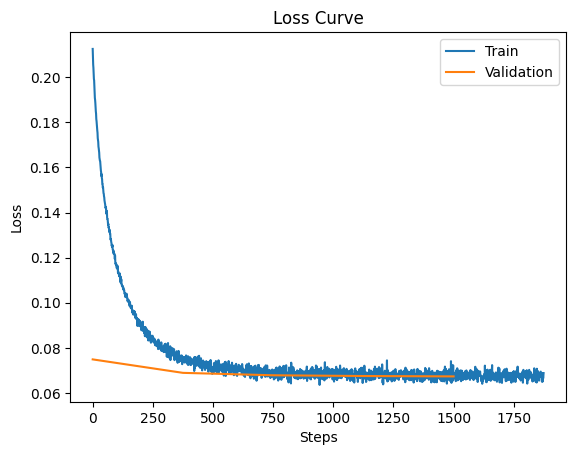

In [272]:
train_losses, val_losses = result["train_losses"], result["val_losses"]

plt.title("Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")

steps_per_epoch = len(train_losses) // len(val_losses)

plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(0, len(train_losses), steps_per_epoch), val_losses, label="Validation")
plt.legend()

### Embeddings

In [273]:
vae = MNISTVAE(latent_dim=LATENT_DIM).to(DEVICE)
vae.load_state_dict(torch.load("./weights.pt"))

<All keys matched successfully>

In [276]:
latents = []
classes = []

model.eval()

with torch.no_grad():
    for X, Y in tqdm(test_loader):
        X = X.to(DEVICE)
        output = vae(X)
        z = output["latent"]

        latents.append(z)
        classes.append(Y)

latents = torch.concat(latents, dim=0).cpu().numpy()
classes = torch.concat(classes, dim=0).cpu().numpy()

latents.size, classes.size

  3%|▎         | 10/375 [00:00<00:03, 99.86it/s]

100%|██████████| 375/375 [00:03<00:00, 103.43it/s]


(96000, 48000)

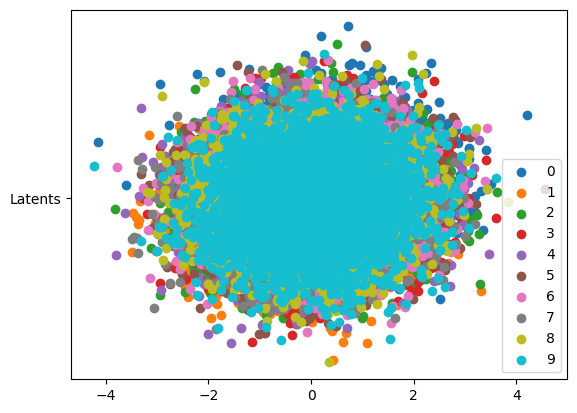

In [277]:
import matplotlib as mpl
import numpy as np

plt.plot("Latents")

cmap = mpl.colormaps['tab10']
colors = [cmap(i/10) for i in range(10)]
colors = np.array(colors)

for i in range(10):
    cls_latents = latents[classes == i]
    plt.scatter(cls_latents[:, 0], cls_latents[:, 1], color=cmap(i/10), label=i)

plt.legend()